## Tutorial for Human Pose Estimation

In [1]:
import yaml
import torch
import torch.nn as nn
from tqdm import tqdm
import os

## Dataset with mmBody: 
Point cloud Mesh/Pose reconstruction dataset collected 4D imaging radar. 
    2 train scenes ["Lab1", "Lab2"] and 7 test scenes ["Lab1", "Lab2", "Furnished", "Occlusion", "Rain", "Smoke", "Poor_lighting"] are included. Depth and RGB sensors are 
    implemented without calibration (to be implemented). 
In the library, we provide a dataloader to use mmWave PC data, and predict these human poses. 

### Load the data

In [3]:
from ..dataset.hpe import load_hpe_dataset
# The path contains the radHAR dataset
root =  '/home/junqiao/projects/data/mmpose'
train_dataset, test_dataset = load_hpe_dataset("mmBody", root)

ImportError: attempted relative import with no known parent package

### Visualize the voxel image

torch.Size([4, 5000, 6]) <class 'torch.Tensor'>


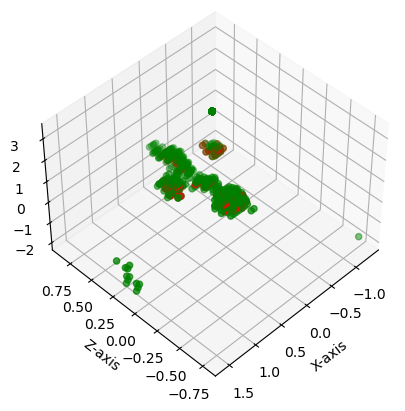

In [6]:
from matplotlib import pyplot as plt
from plot import plot_3d_graph
# Example of the samples in the dataset
index = 9  # Randomly select an index
pc,pose = train_dataset.__getitem__(index)
print(pc.shape, type(pose))
plot_3d_graph(None, pc[0])

## Create model 
mmBody utilizes P4Transformer model as a baseline hpe method. From model.hpe, we can import desired hpe model designed for mmWave PC. The model parameter for P4transformer reimplemented for mmBody is as follows:

In [7]:
from model.hpe import P4Transformer
model = P4Transformer(radius=0.1, nsamples=32, spatial_stride=32,
                  temporal_kernel_size=3, temporal_stride=2,
                  emb_relu=False,
                  dim=1024, depth=10, heads=8, dim_head=256,
                  mlp_dim=2048, num_classes=17*3, dropout1=0.0, dropout2=0.0)
print(model)

P4Transformer(
  (tube_embedding): P4DConv(
    (conv_d): Sequential(
      (0): Conv2d(4, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (conv_f): Sequential(
      (0): Conv2d(3, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp): Sequential()
  )
  (pos_embedding): Conv1d(4, 1024, kernel_size=(1,), stride=(1,))
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_k): Linear(in_features=1024, out_features=2048, bias=False)
              (to_v): Linear(in_features=1024, out_features=2048, bias=False)
              (to_q): Linear(in_features=1024, out_features=2048, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=2048, out_features=1024, bias=True)
                (1): GELU(approximate='none')
                (2): Dropou

A shortcut for loading the hpe model to avoid the tedious hyper-parameter setting.

In [8]:
from model.hpe import load_hpe_model
model = load_hpe_model("mmBody", "P4Transformer")
print(model)

P4Transformer(
  (tube_embedding): P4DConv(
    (conv_d): Sequential(
      (0): Conv2d(4, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (conv_f): Sequential(
      (0): Conv2d(3, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp): Sequential()
  )
  (pos_embedding): Conv1d(4, 1024, kernel_size=(1,), stride=(1,))
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_k): Linear(in_features=1024, out_features=2048, bias=False)
              (to_v): Linear(in_features=1024, out_features=2048, bias=False)
              (to_q): Linear(in_features=1024, out_features=2048, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=2048, out_features=1024, bias=True)
                (1): GELU(approximate='none')
                (2): Dropou

## Model Train
pysensing library support quick training of model with the following steps. The training interface incorporates pytorch loss functions, optimizers and dataloaders to facilate training. An example is provided for how to define the aforemetioned terms.

In [11]:
# Create pytorch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=16, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=16)

# Define pytorch loss function as criterion 
criterion = nn.CrossEntropyLoss()

# Define pytorch optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# GPU acceleration with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A quick training using hpe_train. The resulted model parameters will be saved into "train_{num_epochs}.pth".

In [12]:
# Pysensing training interface
from inference.hpe import hpe_train
hpe_train(model, train_loader, num_epochs=1, optimizer=optimizer, criterion=criterion, device=device)

Epoch:1, MPJPE:51156578067680.9766,Loss:-81202686.124599218
Save model at train_1.pth...


### Model inference

Load the pretrained model, e.g. from train_1.pth, and perform human action recognition!

In [13]:
## load pretrained model
ckpt = torch.load('train_1.pth')['model_state_dict']
model.load_state_dict(ckpt)
model.eval()

P4Transformer(
  (tube_embedding): P4DConv(
    (conv_d): Sequential(
      (0): Conv2d(4, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (conv_f): Sequential(
      (0): Conv2d(3, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp): Sequential()
  )
  (pos_embedding): Conv1d(4, 1024, kernel_size=(1,), stride=(1,))
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_k): Linear(in_features=1024, out_features=2048, bias=False)
              (to_v): Linear(in_features=1024, out_features=2048, bias=False)
              (to_q): Linear(in_features=1024, out_features=2048, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=2048, out_features=1024, bias=True)
                (1): GELU(approximate='none')
                (2): Dropou

In [14]:

idx = 5
voxels,activity= test_dataset.__getitem__(idx)
predicted_result = model(torch.tensor(voxels).unsqueeze(0).float().to(device))
print("The predicted activity is {}, while the ground truth is {}".format(activity,torch.argmax(predicted_result).cpu()))

The predicted activity is tensor([[-0.0055,  3.5388,  0.0039],
        [ 0.0509,  3.5738, -0.0938],
        [ 0.1157,  3.5982, -0.5037],
        [ 0.0735,  3.6879, -0.9271],
        [-0.0663,  3.5698, -0.1087],
        [-0.1262,  3.5920, -0.4973],
        [-0.1188,  3.7011, -0.9247],
        [ 0.0114,  3.5283,  0.2823],
        [-0.0134,  3.5150,  0.5160],
        [ 0.0178,  3.4855,  0.6674],
        [-0.0302,  3.4156,  0.7186],
        [ 0.1854,  3.5322,  0.4721],
        [ 0.4311,  3.5171,  0.3670],
        [ 0.6938,  3.5193,  0.3459],
        [-0.1694,  3.5349,  0.4695],
        [-0.4309,  3.5716,  0.3869],
        [-0.6885,  3.5677,  0.3610]], dtype=torch.float64), while the ground truth is 35


/tmp/ipykernel_54881/3351396857.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_result = model(torch.tensor(voxels).unsqueeze(0).float().to(device))
